In [1335]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)


import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import SVG,display, HTML

import requests
import pickle

from sklearn.neighbors import KDTree

import seaborn as sns

In [569]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow"]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working", "liter", "plenty"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))


tank_keywords = ["tank", "cache"]
def isTank(description):
    return any([kw in description for kw in tank_keywords])
assert(isTank("tank empty"))

In [570]:
# a function that tries to fix a location id, leaves non-waypoint labels alone in case they are in the gps data
# fixes the leading zeros problem WR004 = WR0004
def clean_loc_id(id):
    try:
        waypoint_search = re.search('((?:WR|WA)(?:CS|))([0-9]+)', id, re.IGNORECASE)

        if waypoint_search:        
            waypoint_type = waypoint_search.group(1)
            waypoint_num = waypoint_search.group(2)

            return f"{waypoint_type}{int(waypoint_num):04}"
    except:
        return id
    return id
assert(clean_loc_id("WR004") == "WR0004")

In [482]:
# functions for finding the last positive result and last negative result
def last_pos(mile, date):
    last_pos_date = data[(data.mile == mile) & (data.status==1) & (data.date < date)].date.max()
    if type(last_pos_date) == float:
        return 2000
    return (date - last_pos_date).days
    
def last_neg(mile, date):
    last_neg_date = data[(data.mile == mile) & (data.status==0) & (data.date < date)].date.max()    
    if type(last_neg_date) == float:
        return 2000
    return (date - last_neg_date).days

In [483]:
# create a lat, lon, and name dictionaries keyed on loc_ids 
waypoints = []
for path in glob.glob("gps/*.gpx"):
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    waypoints += (gpx.waypoints)
    
lat = {clean_loc_id(wp.name):wp.latitude for wp in waypoints}
lon = {clean_loc_id(wp.name):wp.longitude for wp in waypoints}

In [549]:
# a generator for sequentially reading in the data
def data_generator():
    for f in glob.glob("pct_data/*.xlsx"):
        data = pd.read_excel(f).dropna()
        _,cols = data.shape
        if cols == 7:
            data.columns = ["map","mile","loc_id","name", "description", "date", "user"]
        if cols == 8:
            data.columns = ["map","mile_2","mile","loc_id","name", "description", "date", "user"]
        yield data

In [550]:
# import and combine tip line data
data_tip = pd.concat(data_generator())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [551]:
# read in guthook data
data_gh=pd.read_csv("guthook_data/PCTWater-wpts-Comments.csv").rename(columns=
    {
        "Date":"date",
        "WptId":"loc_id",
        "WptName":"name",
        "Latitude":"lat",
        "Longitude":"lon",
        "Comment":"description",
        "PCT Mile": "mile"
    })

In [552]:
# clean up the guthook dates
data_gh.date = pd.to_datetime(data_gh.date)

In [553]:
# clean up the lod_ids in the tip line data
data_tip.loc_id = data_tip.loc_id.apply(clean_loc_id)

In [554]:
# create lat and lon columns
data_tip["lat"] = data_tip["loc_id"].map(lat)
data_tip["lon"] = data_tip["loc_id"].map(lon)

In [555]:
# merge the two mile fields in the tip lin data
data_tip.mile = data_tip.mile.fillna(data_tip.mile_2)

In [556]:
# drop data with missing coordinates
data_tip = data_tip.dropna(subset=["lat", "mile"])

In [557]:
# combine report and guthook
data = pd.concat([data_tip, data_gh])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [558]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [559]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [571]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["tank"] = data["description"].map(isTank, na_action="ignore")
data["decision"] = (data.flowing^data.not_flowing)&(~data.tank.astype(bool)) # logical xor
data["status"] = data.flowing.astype(float)

In [572]:
# calculate how much data do I lose after classification
print(f"only one {(data.flowing^data.not_flowing).sum()}")
print(f"at least one {(data.flowing|data.not_flowing).sum()}")
print(f"both {(data.flowing&data.not_flowing).sum()}")
print(f"tank {data.tank.sum()}")


only one 43781
at least one 44859
both 1078
tank 1694


In [573]:
# remove all data with no decision
data = data[data.decision]

In [574]:
# remove duplicate entries (ones with the same date and loc_id)
data = data.drop_duplicates(subset=["date","mile"])

In [622]:
# calculate the day of year features
data['month'] = data.date.map(lambda d:d.month)
data['DOY'] = data.date.dt.dayofyear
data['sinDOY'] = np.sin(2  * np.pi * data.date.dt.dayofyear/365.)
data['cosDOY'] = np.cos(2  * np.pi * data.date.dt.dayofyear/365.)

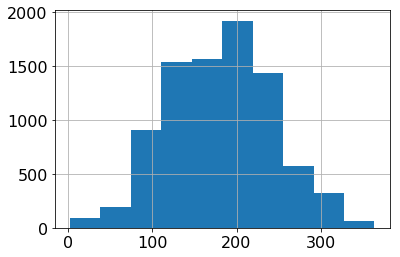

In [987]:
# what does the day of year feature look like?
data.DOY.hist()

In [577]:
# pick which miles we'll focus on
miles = list(data.groupby("mile").nunique().sort_values(by="date")[-150:].loc_id.index)

In [578]:
# remove other data
data = data[data.mile.isin(miles)]

In [579]:
data.shape

(8629, 20)

In [645]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.mile, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.mile, row.date), axis=1)


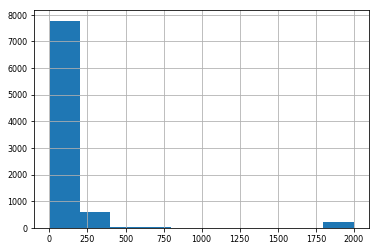

In [581]:
# what does this data look like
data.last_pos.hist()

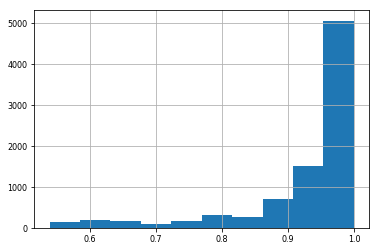

In [769]:
# what does this look like
data.prob_exp.hist(bins=10)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


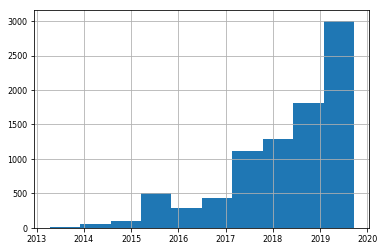

In [770]:
# when does my data come from?
data.date.hist()

In [584]:
# function for 
try:
    f = open('rain_memo_coords.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    print("no rain memo")
    rain_memo = {}

def getRainfall(lat, lon, unix_time):
    lat, lon = round(lat,2),round(lon,2)
    if (lat, lon, unix_time) in rain_memo:
        return rain_memo[(lat,lon, unix_time)]
    print(f"{lat},{lon},{unix_time} not found, calling DarkSky")
    r = requests.get(f"https://api.darksky.net/forecast/840fdc3fb61acc3d4e904978b5ba8dc5/{lat},{lon},{unix_time}?exclude=currently,minutely,hourly,alerts")
    
    try:
        rain = r.json()["daily"]["data"][0]["precipIntensity"]
        rain_memo[(lat, lon, unix_time)] = rain
    except:
        rain = 0
        print(f"Data parse error {lat},{lon},{unix_time}")
        
    f = open('rain_memo_coords.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [585]:
# function for calculating cumulative rain totals
def getRainSum(lat, lon, unix_time, n):
    return 24 * sum([getRainfall(lat, lon, unix_time - (24*60*60*day)) for day in range(0,n)])

In [586]:
# calculate cumulative rain fields
data["rain_5"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 5), axis=1)
data["rain_3"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 3), axis=1)

33.06,-116.53,1523664000 not found, calling DarkSky
33.05,-116.52,1551484800 not found, calling DarkSky
33.05,-116.52,1551398400 not found, calling DarkSky
33.05,-116.52,1551312000 not found, calling DarkSky
33.05,-116.52,1551225600 not found, calling DarkSky
33.05,-116.52,1551139200 not found, calling DarkSky
33.06,-116.53,1524787200 not found, calling DarkSky
33.06,-116.53,1524700800 not found, calling DarkSky
33.06,-116.53,1524614400 not found, calling DarkSky
33.06,-116.53,1524528000 not found, calling DarkSky
33.06,-116.53,1555200000 not found, calling DarkSky
40.05,-121.38,1411948800 not found, calling DarkSky
40.05,-121.38,1411862400 not found, calling DarkSky
40.05,-121.38,1411776000 not found, calling DarkSky
40.05,-121.38,1411689600 not found, calling DarkSky
40.05,-121.38,1411603200 not found, calling DarkSky
40.05,-121.38,1434844800 not found, calling DarkSky
40.05,-121.38,1434758400 not found, calling DarkSky
40.05,-121.38,1434672000 not found, calling DarkSky
40.05,-121.3

In [593]:
data[data.status==0].rain_5_rel.mean()

0.93118864744072638

In [594]:
data[data.status==1].rain_5_rel.mean()

1.0052898780951594

Text(0.5,0,'5 day rainfall relative to source average')

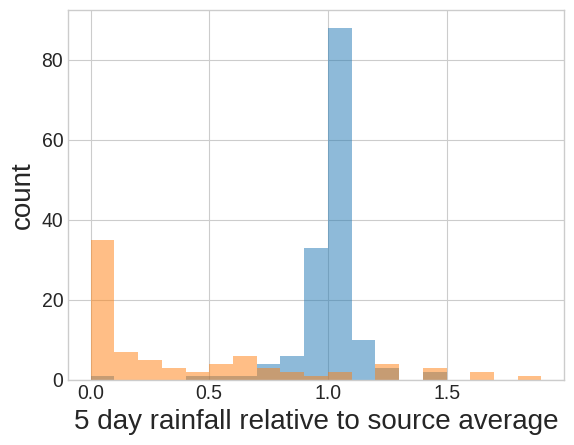

In [1548]:

data[data.status==1].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,2,.1), alpha=0.5)

ax = data[data.status==0].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,2,.1), alpha=0.5)

ax.set_ylabel("count", fontsize=20)
ax.set_xlabel("5 day rainfall relative to source average", fontsize=20)

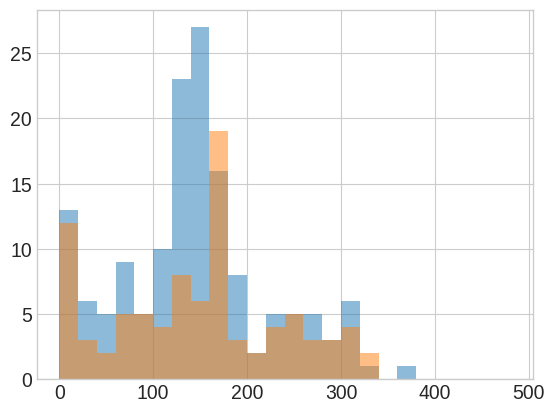

In [1544]:

data[data.status==1].groupby("mile").ground_water.mean().hist(bins=np.arange(0,500,20), alpha=0.5)

data[data.status==0].groupby("mile").ground_water.mean().hist(bins=np.arange(0,500,20), alpha=0.5)

In [596]:
gw = pd.read_csv("ground_water/gwlevels", sep="\t")

In [597]:
def dms2lat(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[0:2], dms[2:4], dms[4:6]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return dd;

def dms2lon(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[6:9], dms[9:11], dms[11:13]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return -dd;

In [598]:
gw["lat"] = gw.site_no.map(dms2lat)
gw["lon"] = gw.site_no.map(dms2lon)

In [599]:
gw = gw[['lev_va', 'lev_dt', 'lat', 'lon', 'site_no']]
gw.columns=["meas", "date", "lat", "lon", 'site_id']

In [600]:
gw["unix_time"] = (pd.to_datetime(gw["date"], errors='coerce').astype(int)//1000000000)
gw["unix_time_reduced"] = gw["unix_time"]//10000000
data["unix_time_reduced"] = gw["unix_time"]//10000000
gw = gw.dropna()

In [601]:
kdt = KDTree(gw[['lat', 'lon', 'unix_time_reduced']])
dist, i = kdt.query(data[['lat', 'lon', 'unix_time_reduced']])

In [602]:
data['ground_water'] = gw.iloc[i.flatten()].meas.values

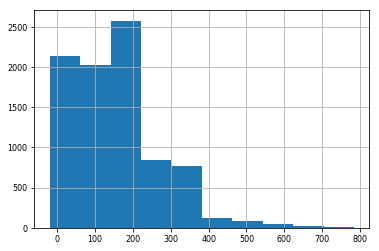

In [603]:
data.ground_water.hist()

In [1268]:
data[data.status==0].sample(10).description

19313    down to a trickle, don't rely on as looks like it'll be dry in days                                                                                                   
391      dry                                                                                                                                                                   
8515     dry at trail. turn right for a small pool to dip or go left after the crossing and follow the creek and listen for a nice small waterfall                             
3820     icky (trail name) no water. no snow to collect at this point. some snow patches a few miles back. water at 285.5 slow moving but collectible and 286.6 has small hole.
9341     stagnant, icky, soon to be dry                                                                                                                                        
2510     nice pool after rainy day. will dry up in a few days                                                           

In [1269]:
def last_result(row):
    try:
        return data[(data.mile==row.mile)&(data.date < row.date)].sort_values("date", ascending=False).status.values[0]
    except:
        return 0

In [1373]:
data["last_result"] = data.apply(last_result, axis=1)

In [1462]:
features = ["rain_5_rel","last_pos","last_neg","prob_exp", "sinDOY", "cosDOY","ground_water"]
data[features+["status"]].corr()

rain_5_rel  last_pos  last_neg      prob_exp    sinDOY  \
rain_5_rel    1.000000e+00  0.019442 -0.020412 -1.675296e-17  0.041810   
last_pos      1.944201e-02  1.000000  0.043713 -1.252176e-01  0.082466   
last_neg     -2.041188e-02  0.043713  1.000000  6.118092e-01 -0.281211   
prob_exp     -1.675296e-17 -0.125218  0.611809  1.000000e+00 -0.348067   
sinDOY        4.180990e-02  0.082466 -0.281211 -3.480666e-01  1.000000   
cosDOY        9.649781e-02  0.071950 -0.164351 -2.632592e-01  0.029361   
ground_water  2.781268e-03  0.019416 -0.099733 -1.207248e-01  0.269255   
status        6.500128e-03 -0.204169  0.239373  4.125968e-01 -0.005729   

                cosDOY  ground_water    status  
rain_5_rel    0.096498  0.002781      0.006500  
last_pos      0.071950  0.019416     -0.204169  
last_neg     -0.164351 -0.099733      0.239373  
prob_exp     -0.263259 -0.120725      0.412597  
sinDOY        0.029361  0.269255     -0.005729  
cosDOY        1.000000  0.119069     -0.219694  
ground_water  0.119069  1.000000     -0.052607  
status       -0.219694 -0.052607      1.000000

In [1570]:
import datetime

data_neg_over = data[data.status == 0].sample(data[data.status == 1].shape[0], replace=True)
data_over = pd.concat([data[data.status == 1], data_neg_over], axis=0)


date_before = datetime.datetime(2019, 4, 1)

#min_max_scaler = MinMaxScaler()
#inputs = min_max_scaler.fit_transform(inputs)

train = data_over[data_over.date < date_before]

test = data_over[data_over.date >= date_before]

print(labels.shape, train.shape,  test.shape)

(16026,) (12380, 38) (3646, 38)


In [1571]:
rain_5_avg_source = train.groupby("mile").rain_5.mean()
train["rain_5_avg"] = train.mile.map(lambda m: rain_5_avg_source.get(m))
train["rain_5_rel"] = train.rain_5 / train.rain_5_avg

test["rain_5_avg"] = test.mile.map(lambda m: rain_5_avg_source.get(m))
test["rain_5_rel"] = test.rain_5 / test.rain_5_avg

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [1572]:
rain_3_avg_source = train.groupby("mile").rain_3.mean()
train["rain_3_avg"] = train.mile.map(lambda m: rain_3_avg_source.get(m))
train["rain_3_rel"] = train.rain_3/ train.rain_3_avg

test["rain_3_avg"] = test.mile.map(lambda m: rain_3_avg_source.get(m))
test["rain_3_rel"] = test.rain_3/ test.rain_3_avg

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [1573]:
# calculate last results normalized by overall measurement frequency per source
last_avg_source = data.groupby("mile")["last"].mean()

train["last_avg"] = train.mile.map(lambda m: last_avg_source.get(m))
train["last_neg_rel"] = train.last_neg / train.last_avg
train["last_pos_rel"] = train.last_pos / train.last_avg


test["last_avg"] = test.mile.map(lambda m: last_avg_source.get(m))
test["last_neg_rel"] = test.last_neg / test.last_avg
test["last_pos_rel"] = test.last_pos / test.last_avg



/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [1574]:
# calculate last results normalized by overall measurement frequency per source
prob_source = data.groupby("mile")["status"].mean()


train["prob_exp"] = train.mile.map(lambda m: prob_source.get(m))
test["prob_exp"] = test.mile.map(lambda m: prob_source.get(m))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1575]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_validate, GroupKFold, KFold, StratifiedKFold

import copy

from graphviz import Source

import time

from matplotlib import cm
from scipy import interpolate

import matplotlib.pyplot as plt

Train size 12380
Test size 3646
tree
              precision    recall  f1-score   support

         0.0       0.39      0.91      0.55       856
         1.0       0.95      0.57      0.71      2790

    accuracy                           0.65      3646
   macro avg       0.67      0.74      0.63      3646
weighted avg       0.82      0.65      0.67      3646

dummy
              precision    recall  f1-score   support

         0.0       0.24      0.59      0.34       856
         1.0       0.77      0.42      0.54      2790

    accuracy                           0.46      3646
   macro avg       0.50      0.51      0.44      3646
weighted avg       0.65      0.46      0.50      3646

most frequent
              precision    recall  f1-score   support

         0.0       0.24      0.58      0.34       856
         1.0       0.77      0.44      0.56      2790

    accuracy                           0.47      3646
   macro avg       0.50      0.51      0.45      3646
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0,0.5,'Precision')

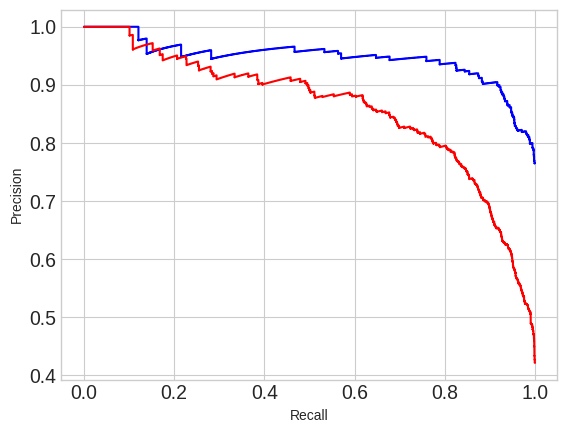

In [1577]:
train = train[features+["status"]].dropna()
test = test[features+["status"]].dropna()

print(f"Train size {train.shape[0]}")
print(f"Test size {test.shape[0]}")

X_train = train[features]
y_train = train.status
X_valid = test[features]
y_valid = test.status


X_train=(X_train-X_train.mean())/X_train.std()
X_valid=(X_valid-X_valid.mean())/X_valid.std()
dt = LogisticRegression().fit(X_train, y_train)
#dt = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#dt = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
#dt = AdaBoostClassifier(learning_rate=0.25,n_estimators=50).fit(X_train, y_train)
#dt = GradientBoostingClassifier().fit(X_train, y_train)

#dt = DecisionTreeClassifier(max_depth = 7, criterion='entropy').fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)


print('tree')
print(classification_report(y_valid, dt.predict(X_valid)))
#print(y_valid[dt_cal.predict(X_valid)].mean())

print('dummy')
print(classification_report(y_valid, dummy.predict(X_valid)))

print('most frequent')
print(classification_report(y_valid, dummy.predict(X_valid)))


#print('last')
#print(classification_report(y_valid, X_valid.last_result))

precision, recall, thresh = precision_recall_curve(y_valid, dt.predict_proba(X_valid)[:,1])

thresh_95 = min([t for (p, t) in zip(precision, thresh) if p > 0.95])
thresh_50 = min([t for (p, t) in zip(precision, thresh) if p > 0.5])
print(thresh_95)
print(thresh_50)


print('95')
print(classification_report(y_valid, dt.predict_proba(X_valid)[:, 1] > thresh_95))

print('50')
print(classification_report(y_valid, dt.predict_proba(X_valid)[:, 1] > thresh_50))
#print(y_valid[dt_cal.predict_proba(X_valid)[:, 1] > 0.8].mean())


plt.step(recall, precision, color='b', alpha=1, where='post')


precision, recall, thresh = precision_recall_curve(y_train, dt.predict_proba(X_train)[:,1])

plt.step(recall, precision, color='r', alpha=1, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')

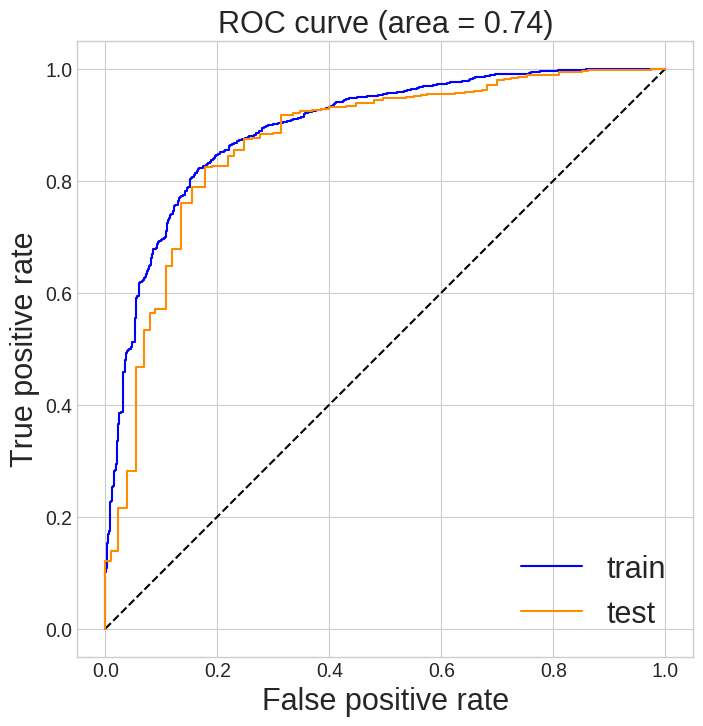

In [1578]:

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)

ax.plot([0, 1], [0, 1], 'k--')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

y_probs = dt.predict_proba(X_train)[:, 1]
y_predicted = dt.predict(X_train)
auc = roc_auc_score(y_train, y_predicted)
false_positive, true_positive, _  = roc_curve(y_train, y_probs)
ax.plot(false_positive, true_positive, color='blue', label='train')


ax.set_aspect(aspect=1)
y_probs = dt.predict_proba(X_valid)[:, 1]
y_predicted = dt.predict(X_valid)
auc = roc_auc_score(y_valid, y_predicted)
false_positive, true_positive, _  = roc_curve(y_valid, y_probs)
ax.plot(false_positive, true_positive, color='darkorange', label='test')
ax.legend(fontsize=22)


plt.xlabel('False positive rate', fontsize=22)
plt.ylabel('True positive rate', fontsize=22)
plt.title('ROC curve (area = %0.2f)' % auc, fontsize=22)
plt.show()

[ 0.29111862 -0.64484754  0.57877406  1.7094279   0.61371606 -0.18913063
 -0.07891983]


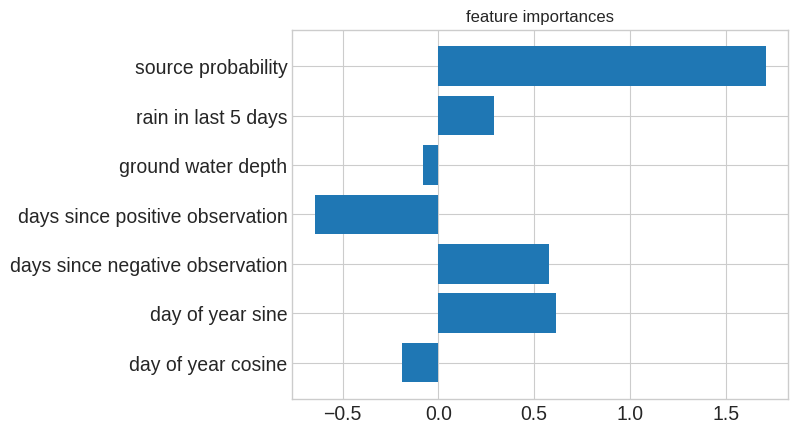

In [1618]:
imp =dt.coef_[0]

names = {
    'cosDOY': 'day of year cosine',
    'sinDOY': 'day of year sine',
    'rain_5_rel': 'rain in last 5 days',
    'prob_exp': 'source probability',
    'last_pos': 'days since positive observation',
    'last_neg': 'days since negative observation',
    'ground_water': 'ground water depth'
}

print(imp)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("feature importances")
ax.barh([names[feat] for feat in X_valid.columns], imp)
#ax.set_xticklabels( ["cosine day of year", "ground water depth", "last negative observation","last positive observation",  "source probability", "rain in last 3 days",  "rain in last 5 days", "sine day of year)"], rotation=45 , ha="right")
plt.show()


(array([ 307.,  166.,   96.,   18.,   13.,   44.,   16.,    8.,    0.,
          36.,    0.,   19.,    0.,   18.,    0.,    0.,    0.,    0.,
          13.,   10.,    0.,    0.,    0.,    0.,   16.,    8.,    9.,
           0.,    0.,    0.,   13.,    0.,    0.,    0.,    0.,    0.,
           0.,   13.,    0.,   14.,    0.,    0.,   19.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98]),
 <a list of 49 Patch objects>)

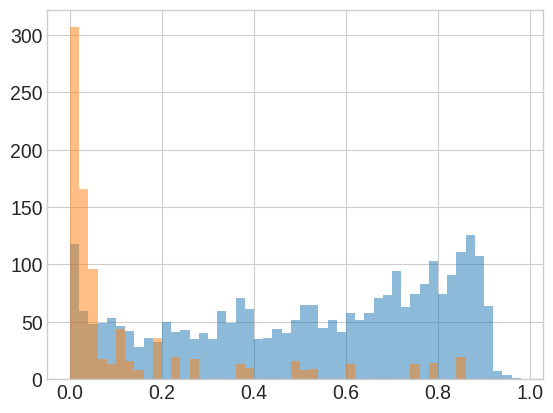

In [1583]:

#plt.hist(dt_cal.predict_proba(X_valid)[:,1], bins=np.arange(0,1,.1))
plt.hist(dt.predict_proba(X_valid)[:,1][y_valid.astype(bool).values], bins=np.arange(0,1,.02), alpha = 0.5)
plt.hist(dt.predict_proba(X_valid)[:,1][~(y_valid.astype(bool).values)], bins=np.arange(0,1,.02),alpha = 0.5)

In [1611]:
features

['rain_5_rel',
 'last_pos',
 'last_neg',
 'prob_exp',
 'sinDOY',
 'cosDOY',
 'ground_water']

In [1613]:
out = []
for mile in miles:
    now = pd.Timestamp.now().round('1d') 
    lat = data[data.mile==mile].lat.values[0]
    lon = data[data.mile==mile].lon.values[0]
    rain_3_avg = data[data.mile==mile].rain_3_avg.values[0]
    rain_5_avg = data[data.mile==mile].rain_5_avg.values[0]
    last_avg = data[data.mile==mile].last_avg.values[0]
    name = data[data.mile==mile].name.mode().values[0]
    
    
    result = {
        'lat': lat, 
        'lon': lon, 
        'name': name,
        'mile': mile
    }
    
    _, i = kdt.query([[lat, lon, (now.value // 10**16) ]])
    ground_water = gw.iloc[i.flatten()].meas.values[0]
    
    for days in range(4):
        prediction = dt_cal.predict_proba([[ 
                    getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 5)/rain_5_avg, 
                    (last_pos(mile, now) + days),
                    (last_neg(mile, now) + days),
                    data[mile == data.mile].status.mean(),
                    np.sin(2  * np.pi * now.dayofyear/365.),
                    np.cos(2  * np.pi * now.dayofyear/365.),
                    ground_water
                ]])
        result[f'prediction_{days}'] = prediction[0][1]
    
    out.append(result)

    
f = open('out_combined.pkl', 'wb')
pickle.dump(out, f)
f.close() 

34.3,-116.96,1570147200 not found, calling DarkSky
34.3,-116.96,1570233600 not found, calling DarkSky
34.3,-116.96,1570320000 not found, calling DarkSky
47.46,-121.3,1570060800 not found, calling DarkSky
47.46,-121.3,1569974400 not found, calling DarkSky
47.46,-121.3,1569888000 not found, calling DarkSky
47.46,-121.3,1570147200 not found, calling DarkSky
47.46,-121.3,1570233600 not found, calling DarkSky
47.46,-121.3,1570320000 not found, calling DarkSky
46.46,-121.42,1570060800 not found, calling DarkSky
46.46,-121.42,1569974400 not found, calling DarkSky
46.46,-121.42,1569888000 not found, calling DarkSky
46.46,-121.42,1570147200 not found, calling DarkSky
46.46,-121.42,1570233600 not found, calling DarkSky
46.46,-121.42,1570320000 not found, calling DarkSky
40.05,-121.38,1570060800 not found, calling DarkSky
40.05,-121.38,1569974400 not found, calling DarkSky
40.05,-121.38,1569888000 not found, calling DarkSky
40.05,-121.38,1570147200 not found, calling DarkSky
40.05,-121.38,1570233

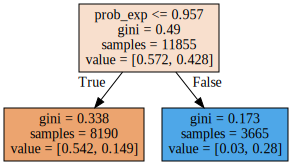

In [1295]:
graph = Source( export_graphviz(dt.estimators_[0], out_file=None, feature_names=X_test.columns, filled=True))


SVG(graph.pipe(format='svg'))

In [841]:
data.groupby("mile").count().sort_values(by="date", ascending=False).head(20)

Elevation(m)  date  description  lat  loc_id  lon  map  mile_2  name  \
mile                                                                           
4.4     98            141   141          141  141     141  43   0       141    
583.3   112           135   135          135  135     135  23   0       135    
487.1   98            123   123          123  123     123  25   0       123    
101.1   74            117   117          117  117     117  43   0       117    
668.7   96            117   117          117  117     117  21   0       117    
105.0   71            111   111          111  111     111  40   0       111    
463.2   108           108   108          108  108     108  0    0       108    
683.1   94            108   108          108  108     108  14   0       108    
15.4    62            104   104          104  104     104  42   0       104    
602.1   101           101   101          101  101     101  0    0       101    
411.0   84            98    98           98   98      98   14   0       98     
541.5   97            97    97           97   97      97   0    0       97     
608.9   70            94    94           94   94      94   24   0       94     
333.1   80            94    94           94   94      94   14   0       94     
37.8    89            89    89           89   89      89   0    0       89     
1799.3  76            84    84           84   84      84   8    7       84     
680.8   67            83    83           83   83      83   16   0       83     
32.0    48            82    82           82   82      82   34   0       82     
383.7   67            81    81           81   81      81   14   0       81     
1459.6  80            80    80           80   80      80   0    0       80     

        user  ...  rain_3_avg  rain_3_rel  unix_time_reduced  ground_water  \
mile          ...                                                            
4.4     43    ...  141         141         141                141            
583.3   23    ...  135         135         135                135            
487.1   25    ...  123         123         123                123            
101.1   43    ...  117         117         117                117            
668.7   21    ...  117         117         117                117            
105.0   40    ...  111         111         111                111            
463.2   0     ...  108         108         108                108            
683.1   14    ...  108         108         108                108            
15.4    42    ...  104         104         104                104            
602.1   0     ...  101         101         101                101            
411.0   14    ...  98          98          98                 98             
541.5   0     ...  97          97          97                 97             
608.9   24    ...  94          94          94                 94             
333.1   14    ...  94          94          94                 94             
37.8    0     ...  89          89          89                 89             
1799.3  8     ...  84          84          84                 84             
680.8   16    ...  83          83          83                 83             
32.0    34    ...  82          82          82                 82             
383.7   14    ...  81          81          81                 81             
1459.6  0     ...  80          80          80                 80             

        cosDOY  last  last_avg  last_neg_rel  last_pos_rel  last_result  
mile                                                                     
4.4     141     141   141       141           141           141          
583.3   135     135   135       135           135           135          
487.1   123     123   123       123           123           123          
101.1   117     117   117       117           117           117          
668.7   117     117   117       117           117           117          
105.0   111 

Text(0.5,0,'year')

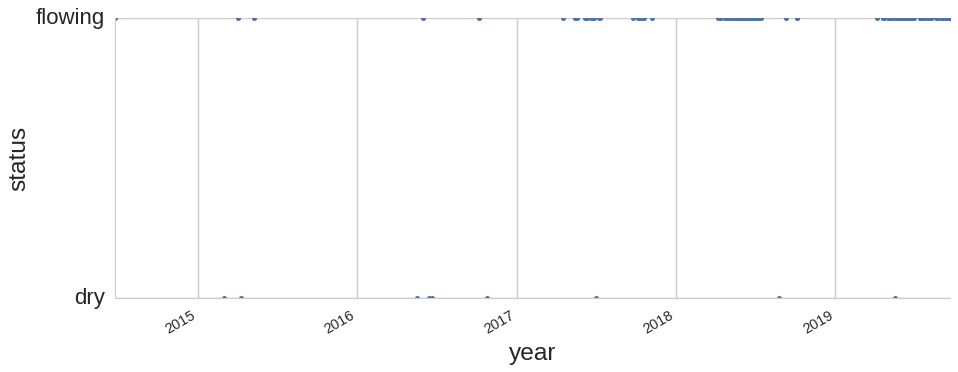

In [1337]:
ax = data[data.mile==668.7].plot(x="date", y="status", style=".", figsize=(12,5), legend=False)
#display(data[data.mile==668.7])
ax.set_yticks([0, 1]);
ax.set_yticklabels([ "dry","flowing"], fontsize=20);
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

plt.ylabel("status", fontsize=22) 
plt.xlabel("year", fontsize=22) 

Text(0.5,0,'year')

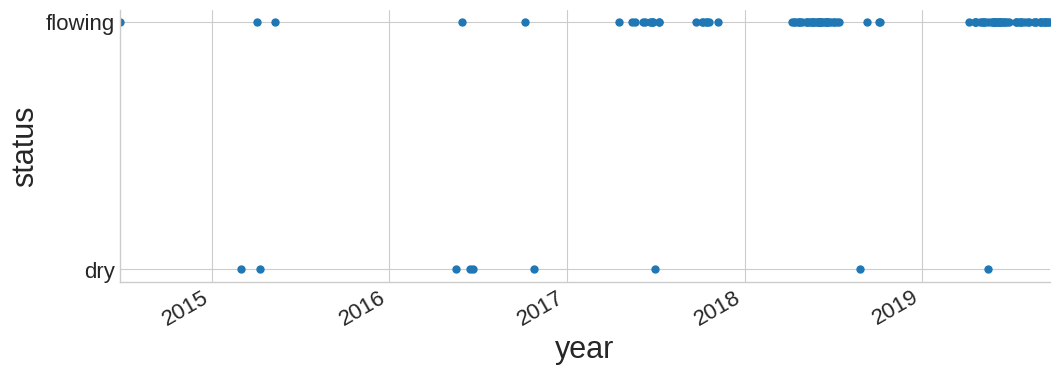

In [1485]:
ax = data[data.mile==668.7].plot(x="date", y="status", style=".", figsize=(12,4), legend=False,markersize=10)
#display(data[data.mile==668.7])
ax.set_yticks([0, 1]);
ax.set_yticklabels([ "dry","flowing"]);
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

plt.ylabel("status", fontsize=22) 
plt.xlabel("year", fontsize=22) 

In [1352]:
import matplotlib.style as style

style.use('seaborn-whitegrid') #sets the size of the charts
style.available


['seaborn-colorblind',
 'ggplot',
 'fast',
 'Solarize_Light2',
 'dark_background',
 'seaborn-darkgrid',
 'seaborn-whitegrid',
 'seaborn-pastel',
 'seaborn-paper',
 '_classic_test',
 'classic',
 'seaborn-white',
 'seaborn-deep',
 'fivethirtyeight',
 'seaborn-notebook',
 'seaborn-muted',
 'seaborn-dark',
 'grayscale',
 'seaborn',
 'seaborn-ticks',
 'seaborn-poster',
 'seaborn-dark-palette',
 'bmh',
 'seaborn-talk',
 'seaborn-bright']

In [1329]:
import matplotlib.pyplot as plt

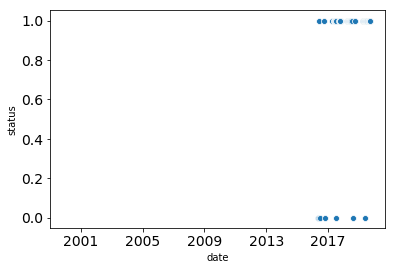

In [1265]:
ax = sns.scatterplot(x="date", y="status", data=data[(data.date.dt.year > 2015) &(data.mile==668.7)])

In [1278]:
train = train[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY", "status"]].dropna()
test = test[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY", "status"]].dropna()

print(f"Train size {train.shape[0]}")
print(f"Test size {test.shape[0]}")

X_train = train[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY"]]
y_train = train.status
X_test = test[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY"]]
y_test = test.status


#dt = LogisticRegression(penalty="elasticnet").fit(X_train, y_train)
#dt = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#dt = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
dt = AdaBoostClassifier(n_estimators = 100).fit(X_train, y_train)
#dt = DecisionTreeClassifier(max_depth = 7, criterion='entropy').fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

dt_cal = CalibratedClassifierCV(dt, cv='prefit').fit(X_train, y_train)
dummy_cal = CalibratedClassifierCV(dummy, cv='prefit').fit(X_train, y_train)
dummy_majority_cal = CalibratedClassifierCV(dummy_majority, cv='prefit').fit(X_train, y_train)


classifiers = []
reports = []
cv = StratifiedKFold(n_splits=5, random_state=0)
for train_index, test_index in cv.split(X_train, y=y_train):
    xt, xv, yt, yv = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    dt.fit(xt, yt)
    classifiers.append(copy.copy(dt))
    reports.append(classification_report(yv, dt.predict(xv), output_dict=True))

dt.fit(X_test, y_test)
classifiers.append(copy.copy(dt))
reports.append(classification_report(y_test, dt.predict(X_test), output_dict=True))


#print('last')
#print(classification_report(y_valid, X_valid.last_result))

precision, recall, thresh = precision_recall_curve(y_valid, dt.predict_proba(X_valid)[:,1])

thresh_95 = min([t for (p, t) in zip(precision, thresh) if p > 0.95])
thresh_50 = min([t for (p, t) in zip(precision, thresh) if p > 0.5])
print(thresh_95)
print(thresh_50)

for p, t in zip(precision, thresh):
    if p > 0.5:
        print (p,t)
        break


plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

KeyError: "['last_pos_rel', 'last_neg_rel'] not in index"

In [1589]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [1600]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data_over.description
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)


In [1607]:
true_k = 4
model = KMeans(n_clusters=true_k)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [1608]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [1609]:
for i in range(true_k):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]}")

Cluster 0:
flowing
well
still
strong
great
water
good
clear
very
cold
Cluster 1:
dry
as
zuckerbergs
eat
either
eight
effective
eeyore
eerily
edward
Cluster 2:
dry
water
flowing
the
no
15
is
flow
18
of
Cluster 3:
flow
good
great
strong
still
water
cold
nice
clear
very
